In [117]:
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [118]:

# Adjust display options
#pd.set_option('display.max_rows', 600)  # Display all rows
#pd.set_option('display.max_columns', None)  # Display all columns
#pd.set_option('display.width', None)  # Allow unlimited width for display

# Initialize empty list 
dfs = []
participant_ids = []

# Iterate through each CSV file in the folder
pathlist = Path("data/").rglob('*.csv')
for participant_id, path in enumerate(pathlist, start=1):
    df = pd.read_csv(path)
    dfs.append(df)
    participant_ids.extend([participant_id] * len(df))

# Concatenate all DataFrames in the list into one DataFrame
combined_df = pd.concat(dfs, ignore_index=True)
combined_df['participant_id'] = participant_ids
#print(combined_df)

# Reorder columns to place participant ID column first
cols = combined_df.columns.tolist()
cols = ['participant_id'] + [col for col in cols if col != 'participant_id']
combined_df = combined_df[cols]

# Clean data
combined_df = combined_df.dropna()
combined_df = combined_df[combined_df.rt != -1]

true_false_lst_mov = []
true_false_lst_or = []

# Iterate through each task type
for task_type in combined_df['task_type'].unique():
    # Filter the DataFrame for the current task type
    task_data = combined_df[combined_df['task_type'] == task_type]
    
    # Iterate through each participant
    for i in range(1, max(task_data['participant_id']) + 1):
        # Filter the DataFrame for the current participant and task type
        participant_data = task_data[(task_data['participant_id'] == i)]
        
        # Count the True and False answers for the current participant
        true_count = participant_data['correct'].eq(True).sum()
        false_count = participant_data['correct'].eq(False).sum()
        total_count = true_count + false_count
        
        # Calculate ratio
        if total_count > 0:
            ratio_count = true_count / total_count
        else:
            ratio_count = 0.0
        
        # Create a dictionary with the counts for the current participant and task type
        bool_dict = {
            "Participant": i,
            "Task_Type": task_type,
            "True": true_count,
            "False": false_count,
            "ratio": ratio_count
        }
        
        # Append the dictionary to respective list based on task type
        if task_type == 'mov':
            true_false_lst_mov.append(bool_dict)
        elif task_type == 'or':
            true_false_lst_or.append(bool_dict)


# Get the intersection of the two lists to find participants meeting both conditions
selected_ids_mov = [x['Participant'] for x in true_false_lst_mov if x['ratio'] >= 0.8]
selected_ids_or = [x['Participant'] for x in true_false_lst_or if x['ratio'] >= 0.8]
selected_ids = list(set(selected_ids_mov).intersection(selected_ids_or))

# Filter the combined_df based on the selected_participant_ids
filtered_df = combined_df[combined_df.participant_id.isin(selected_ids)]


# extra df for plots
df_repetition = filtered_df[filtered_df['task_transition'] == 'repetition']
df_switch = filtered_df[filtered_df['task_transition'] == 'switch']
df_or = filtered_df[filtered_df.task_type != "or"]
df_mov = filtered_df[filtered_df.task_type != "mov"]

filtered_df
#combined_df
#for entry in true_false_lst_or:
#    print(entry)
#for entry in true_false_lst_mov:
#    print(entry)
#for entry in true_false_lst_or:
#    print(entry)
#selected_ids
#len(selected_ids)


,participant_id,rt,key_press,correct,coherent_movement_direction,coherent_orientation,task_type,task_transition,congruency
1,1,1164,f,True,180,180,or,repetition,congruent
2,1,1502,j,True,180,0,or,repetition,incongruent
3,1,1155,j,True,0,0,mov,switch,congruent
4,1,727,j,True,0,0,mov,repetition,congruent
5,1,677,j,True,0,0,mov,repetition,congruent
...,...,...,...,...,...,...,...,...,...
3067,32,1358,f,True,180,180,mov,switch,congruent
3068,32,1694,f,True,180,180,or,switch,congruent
3069,32,619,f,True,180,0,mov,switch,incongruent
3070,32,565,j,True,0,180,mov,repetition,incongruent


In [ ]:
"""
Getting total True_False answers
"""
"""
# Iterate through each participant
for i in range(1, max(combined_df.participant_id) + 1):
    # Filter the DataFrame for the current participant
    participant_data = combined_df[combined_df.participant_id == i]
    
    # Count the True and False answers for the current participant and its ratio
    true_count = participant_data['correct'].eq(True).sum()
    false_count = participant_data['correct'].eq(False).sum()
    ratio_count = true_count / (true_count + false_count) 
    
    # Create a dictionary with the counts
    bool_dict_total = {
        "Participant": i,
        "True": true_count,
        "False": false_count,
        "ratio": ratio_count
    }
    
    # Append the dictionary to the list
    true_false_lst.append(bool_dict)

"""

In [ ]:
# Visualization 1: Distribution of Reaction Times
plt.figure(figsize=(10, 6))
sns.histplot(data=filtered_df, x="rt", kde=True, bins=30)
plt.title('Distribution of Reaction Times')
plt.xlabel('Reaction Time (ms)')
plt.ylabel('Frequency')
plt.show()

# Visualization 2: Accuracy by Task Type
plt.figure(figsize=(10, 6))
sns.barplot(x="task_type", y="correct", data=filtered_df, estimator=lambda x: sum(x.astype(int)) / len(x) * 100)
plt.title('Accuracy by Task Type')
plt.xlabel('Task Type')
plt.ylabel('Percentage Correct (%)')
plt.ylim(80, 100)
plt.show()

# Visualization 3: Reaction Time by Congruency
plt.figure(figsize=(10, 6))
sns.boxplot(x="congruency", y="rt", data=filtered_df)
plt.title('Reaction Time by Congruency')
plt.xlabel('Congruency')
plt.ylabel('Reaction Time (ms)')
plt.show()

# Visualization 4: Task Transition Effects on Reaction Time
plt.figure(figsize=(10, 6))
sns.boxplot(x="task_transition", y="rt", data=filtered_df)
plt.title('Effect of Task Transition on Reaction Time')
plt.xlabel('Task Transition')
plt.ylabel('Reaction Time (ms)')
plt.show()

# Visualization 5: Reaction Times for Repetition Tasks by Congruency
plt.figure(figsize=(10, 6))
sns.boxplot(x="task_transition", y="rt", hue="congruency", data=df_repetition)
plt.title('Reaction Times for Repetition Tasks by Congruency')
plt.xlabel('Task Transition (Repetition)')
plt.ylabel('Reaction Time (ms)')
plt.legend(title='Congruency')
plt.show()

# Visualization 6: Reaction Times for Switch Tasks by Congruency
plt.figure(figsize=(10, 6))
sns.boxplot(x="task_transition", y="rt", hue="congruency", data=df_switch)
plt.title('Reaction Times for Switch Tasks by Congruency')
plt.xlabel('Task Transition (Switch)')
plt.ylabel('Reaction Time (ms)')
plt.legend(title='Congruency')
plt.show()

# Visualization 7: Reaction Time for task_type "or" by Congruency
plt.figure(figsize=(10, 6))
sns.boxplot(x="congruency", y="rt", data=df_or)
plt.title('Reaction Time for task_type "or" by Congruency')
plt.xlabel('Congruency')
plt.ylabel('Reaction Time (ms)')
plt.show()

# Visualization 8: Reaction Time for task_type "mov" by Congruency
plt.figure(figsize=(10, 6))
sns.boxplot(x="congruency", y="rt", data=df_mov)
plt.title('Reaction Time for task_type "mov" by Congruency')
plt.xlabel('Congruency')
plt.ylabel('Reaction Time (ms)')
plt.show()



In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import arviz as az
import hssm
import hssm.plotting
hssm.set_floatX("float32")

In [ ]:
def run_ddm(drift_rate = 1,
            threshold = 1,
            starting_point = 0.5,
            noise_std = 1,
            non_decision_time = 0,
            dt = 1,
            max_time = 2000,
            task_transition = 0 ):
    """
    Simulates the Drift Diffusion Model for one run with fixed time increments to match evidence points.

    Parameters are the same as the previous function.

    Arguments:
    - drift_rate: rate of evidence accumulation
    - threshold: evidence needed to reach a decision
    - starting_point: initial condition of the evidence
    - noise_std: standard deviation of the noise term
    - non_decision_time: time not included in the evidence accumulation process
    - dt: time increment
    - max_time: maximum simulation time
    - task_transition: task transition 0 = repetition, 1 = switch

    Returns:
    - decision_time: the time taken to reach a decision
    - evidence_over_time: the evidence accumulated over time
    - decision: 1 if the decision boundary reached is the upper threshold, -1 if lower
    """
        # Initialize evidence accumulation process
    time = non_decision_time
    evidence = starting_point
    evidence_over_time = [evidence]

    # Run the simulation until a decision boundary is reached or max time is exceeded
    while time < max_time:
        # Adjust drift rate based on task transition
        current_drift_rate = drift_rate if task_transition == 0 else -drift_rate

        # Increment the evidence by the drift and some noise
        evidence += current_drift_rate * dt + np.sqrt(dt) * noise_std * np.random.normal()
        evidence_over_time.append(evidence)
        time += dt  # Increment the time

        # Check if the evidence has reached either threshold
        if evidence >= threshold:
            return time, evidence_over_time, 1  # Decision made for the upper threshold
        elif evidence <= 0:
            return time, evidence_over_time, -1  # Decision made for the lower threshold

    # If no decision has been made by max_time, return the current state
    return time, evidence_over_time, 0


In [ ]:
v = 0.1          # drift rate
a = 200           # threshold
z = a/2           # starting point (between 0 and threshold a)
sigma = 1         # standard deviation of noise
t0 = 0            # non-decision time
dt = 1            # integration constant
max_time = 2000   # maximum number of simulated ms
task_transition = [0,1] # task transition 0 = repetition, 1 = switch
for i in task_transition:
    # Run the simulation with the fixed function
    decision_time, evidence_over_time, decision = run_ddm(drift_rate = v,
                                                        threshold = a,
                                                        starting_point = z,
                                                        noise_std = sigma,
                                                        non_decision_time = t0,
                                                        dt = dt,
                                                        max_time = max_time,
                                                        task_transition = i)

    # Plot the results with the correct matching of time and evidence points
    plt.plot(np.linspace(t0+0, t0+decision_time, len(evidence_over_time)), evidence_over_time)
    plt.axhline(y=a, color='green', linestyle='--')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Time (ms)')
    plt.ylabel('Evidence')
    plt.title(f'Drift Diffusion Model (Decision: {"Upper" if decision == 1 else "Lower" if decision == 0 else "None"})')
    plt.show()

In [ ]:
def plot_ddm_histograms(rt_upper_simulated, rt_lower_simulated, rt_upper_empirical = None, rt_lower_empirical = None, y_max = 0.5):

  # Calculate the weights for each group to normalize the histograms
  weights_upper_simulated = np.ones_like(rt_upper_simulated) / float(len(rt_upper_simulated)+len(rt_lower_simulated))
  weights_lower_simulated = np.ones_like(rt_lower_simulated) / float(len(rt_upper_simulated)+len(rt_lower_simulated))

  if rt_upper_empirical is not None and rt_lower_empirical is not None:
    weights_upper_empirical = np.ones_like(rt_upper_empirical) / float(len(rt_upper_empirical)+len(rt_lower_empirical))
    weights_lower_empirical = np.ones_like(rt_lower_empirical) / float(len(rt_upper_empirical)+len(rt_lower_empirical))

  # set up figure
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

  # Plot the histograms for upper threshold
  axs[0].hist(rt_upper_simulated, bins=30, weights=weights_upper_simulated, alpha=0.5, color='blue', label='Simulated DDM')
  if rt_upper_empirical is not None:
    axs[0].hist(rt_upper_empirical, bins=30, weights=weights_upper_empirical, alpha=0.5, color='orange', label='Empirical Data')
  axs[0].set_xlabel('Reaction Time (ms)')
  axs[0].set_ylabel('Normalized Frequency')
  axs[0].legend()
  axs[1].set_ylim([0, y_max])
  axs[0].set_title('Upper Threshold')

  # Plot the histograms for lower threshold
  axs[1].hist(rt_lower_simulated, bins=30, weights=weights_lower_simulated, alpha=0.5, color='blue', label='Simulated DDM')
  if rt_upper_empirical is not None:
    axs[1].hist(rt_lower_empirical, bins=30, weights=weights_lower_empirical, alpha=0.5, color='orange', label='Empirical Data')
  axs[1].set_xlabel('Reaction Time (ms)')
  axs[1].set_ylabel('Normalized Frequency')
  axs[1].legend()
  axs[0].set_ylim([0, y_max])
  axs[1].set_title('Lower Threshold')

  # Adjust layout
  plt.tight_layout()

  # Display the figure
  plt.show()

In [74]:
dataset = filtered_df

# collect data for histogram
filtered_rt_lower = dataset[dataset['task_transition'] == 'switch']['rt']
rt_lower_empirical = filtered_rt_lower.to_numpy()

filtered_rt_upper = dataset[dataset['task_transition'] == 'repetition']['rt']
rt_upper_empirical = filtered_rt_upper.to_numpy()

# print data set
rt_lower_empirical
#rt_upper_empirical
#dataset

array([1155,  992,  704, 1406,  634, 1112,  470,  727, 1111,  709,  688,
        711,  730,  689, 1119,  948,  954,  692,  989,  901, 1385,  458,
        671,  491,  775,  414,  966,  413,  883, 1073,  795,  357,  637,
        890,  571, 1002,  708,  351,  781,  344,  674,  910,  675,  394,
        747,  511,  788, 1160, 1055, 1715, 2008, 1077,  982, 1344, 1137,
        897, 1319, 1432, 1382,  624, 1235,  826, 1402,  954,  954, 1015,
       1579,  910,  851,  993,  764,  831,  936,  798,  901,  578,  848,
        665,  925, 1190, 1586,  726,  545, 1286, 1098, 1122,  718, 1228,
        733, 1246,  689,  855,  570, 1001,  691,  982,  823, 1544,  814,
       1686,  568,  887,  656, 1199,  668,  866,  881, 1011, 1435,  892,
        607, 1527, 1872, 1096,  946, 1046, 1208,  819, 1447, 1589,  572,
        777,  466, 1234,  550,  634,  688,  684, 1239, 1122, 1186,  762,
        646,  594,  990,  856, 1126,  567,  985,  564, 1031,  800, 1255,
       1584, 1669, 1010,  647,  606,  862,  655,  8

In [ ]:
# ADJUST THESE PARAMETERS FOR THE EXERCISE
v = 0.06         # drift rate
a = 200          # threshold
t0 = 300         # non-decision time

# DO NOT ADJUST THESE PARAMETERS FOR THE EXERCISE, THEY REMAIN FIXED
sigma = 3         # standard deviation of noise
dt = 1         # integration constant
z = 100           # starting point (between 0 and threshold a)
task_transition = [0,1] # task transition 0 = repetition, 1 = switch

# Plotting parameters
y_max = 0.1       # maximum of y-axsis (you may have to adjust this)

# simulation parameters [DO NOT ADJUST]
num_simulations = 3000  # number of simulated reaction times
max_time = 2000   # maximum number of simulated seconds

rt_upper = []           # list used to store reaction times for upper boundary
rt_lower = []           # list used to store reaction times for lower boundary

# simulate the DDM a number of times
np.random.seed(0) # DO NOT REMOVE SEED
for i in [0,1]:
    for sim in range(num_simulations):

        # for each simulation, retrive the decision, the evidence trace, and decision time
        decision_time, evidence_over_time, decision = run_ddm(drift_rate = v,
                                                                threshold = a,
                                                                starting_point = z,
                                                                noise_std = sigma,
                                                                non_decision_time = t0,
                                                                dt = dt,
                                                                max_time = max_time,
                                                                task_transition = i)

        # if the simulation hit the lower bound, add decision time to list of lower reaction times
        if decision == -1:
            rt_lower.append(decision_time)
        # if the simulation hit the upper bound, add decision time to list of lower upper times
        elif decision == 1:
            rt_upper.append(decision_time)

    plot_ddm_histograms(rt_upper, rt_lower, rt_upper_empirical, rt_lower_empirical, y_max = y_max)

In [ ]:
# Define parameters
v = 0.1  # Drift rate ulation time

# Define task conditions
task_type = 'orientation'
coherent_movement_direction = 0
coherent_orientation_direction = 0
congruency = 'congruent'
task_transition = 'repetition'  # or 'switch'

# Run the DDM simulation
for i in ['repetition','switch']:
    decision_time, evidence_over_time, decision = run_task_switching_ddm(
        task_type=task_type,
        coherent_movement_direction=coherent_movement_direction,
        coherent_orientation_direction=coherent_orientation_direction,
        congruency=congruency,
        task_transition=task_transition,
        drift_rate_baseline=v,
        threshold_baseline=a,
        non_decision_time_baseline=t0,
        noise_std=sigma,
        dt=dt,
        max_time=max_time
    )

    # Plot the results
    plt.plot(np.linspace(t0, t0 + decision_time, len(evidence_over_time)), evidence_over_time)
    plt.axhline(y=a, color='green', linestyle='--')  # Upper threshold
    plt.axhline(y=-a, color='red', linestyle='--')  # Lower threshold
    plt.xlabel('Time (ms)')
    plt.ylabel('Evidence')
    plt.title(f'Drift Diffusion Model (Decision: {"Upper" if decision == 1 else "Lower" if decision == -1 else "None"})')
    plt.show()

In [77]:
from pyddm import Model, Fittable, Fitted
from pyddm.models import LossRobustBIC, DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision, ICPointSourceCenter
from pyddm.functions import fit_adjust_model, display_model

model = Model(name='Task_Switching',
              drift=DriftConstant(drift=2.2),
              noise=NoiseConstant(noise=1.5),
              bound=BoundConstant(B=1.1),
              overlay=OverlayNonDecision(nondectime=.003),
              dx=.001, dt=.001, T_dur=2)
display_model(model)
sol = model.solve()

Model Task_Switching information:
Choices: 'correct' (upper boundary), 'error' (lower boundary)
Drift component DriftConstant:
    constant
    Fixed parameters:
    - drift: 2.200000
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.500000
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.100000
IC component ICPointSourceCenter:
    point_source_center
    (No parameters)
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fixed parameters:
    - nondectime: 0.003000



In [85]:
samp = sol.resample(1000)

In [86]:

model_fit = Model(name='Simple model (fitted)',
                  drift=DriftConstant(drift=Fittable(minval=0, maxval=4)),
                  noise=NoiseConstant(noise=Fittable(minval=.5, maxval=4)),
                  bound=BoundConstant(B=1.1),
                  overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=1)),
                  dx=.001, dt=.01, T_dur=2)

fit_adjust_model(samp, model_fit,
                 fitting_method="differential_evolution",
                 lossfunction=LossRobustBIC, verbose=False)

Info: Params [2.15257770e+00 1.47415336e+00 1.31843974e-03] gave 519.123667080996


Model(name='Simple model (fitted)', drift=DriftConstant(drift=Fitted(2.1525776950642124, minval=0, maxval=4)), noise=NoiseConstant(noise=Fitted(1.4741533570630623, minval=0.5, maxval=4)), bound=BoundConstant(B=1.1), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.0013184397449907403, minval=0, maxval=1)), dx=0.001, dt=0.01, T_dur=2, fitresult=FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=519.123667080996, nparams=3, samplesize=1000, mess=''))

In [87]:
model_fit.parameters()

{'drift': {'drift': Fitted(2.1525776950642124, minval=0, maxval=4)},
 'noise': {'noise': Fitted(1.4741533570630623, minval=0.5, maxval=4)},
 'bound': {'B': 1.1},
 'IC': {},
 'overlay': {'nondectime': Fitted(0.0013184397449907403, minval=0, maxval=1)}}

In [81]:
model_fit.get_fit_result().value()

379.0714451708533

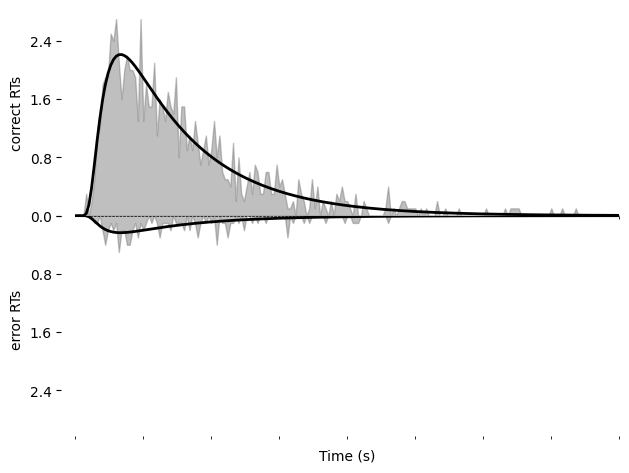

In [82]:
import pyddm.plot
import matplotlib.pyplot as plt
pyddm.plot.plot_fit_diagnostics(model=model_fit, sample=samp)
plt.show()

In [88]:
print(sol.prob("correct"))
print(sol.pdf("error"))

0.89425603140374
[0.         0.         0.         ... 0.00059962 0.0005976  0.00059559]


In [142]:

# Adjust display options
#pd.set_option('display.max_rows', 600)  # Display all rows
#pd.set_option('display.max_columns', None)  # Display all columns
#pd.set_option('display.width', None)  # Allow unlimited width for display

# Initialize empty list 
dfs = []
participant_ids = []

# Iterate through each CSV file in the folder
pathlist = Path("data/").rglob('*.csv')
for participant_id, path in enumerate(pathlist, start=1):
    df = pd.read_csv(path)
    dfs.append(df)
    participant_ids.extend([participant_id] * len(df))

# Concatenate all DataFrames in the list into one DataFrame
combined_df = pd.concat(dfs, ignore_index=True)
combined_df['participant_id'] = participant_ids
#print(combined_df)

# Reorder columns to place participant ID column first
cols = combined_df.columns.tolist()
cols = ['participant_id'] + [col for col in cols if col != 'participant_id']
combined_df = combined_df[cols]

# Clean data
combined_df = combined_df.dropna()
combined_df = combined_df[combined_df.rt != -1]

true_false_lst_mov = []
true_false_lst_or = []

# Iterate through each task type
for task_type in combined_df['task_type'].unique():
    # Filter the DataFrame for the current task type
    task_data = combined_df[combined_df['task_type'] == task_type]
    
    # Iterate through each participant
    for i in range(1, max(task_data['participant_id']) + 1):
        # Filter the DataFrame for the current participant and task type
        participant_data = task_data[(task_data['participant_id'] == i)]
        
        # Count the True and False answers for the current participant
        true_count = participant_data['correct'].eq(True).sum()
        false_count = participant_data['correct'].eq(False).sum()
        total_count = true_count + false_count
        
        # Calculate ratio
        if total_count > 0:
            ratio_count = true_count / total_count
        else:
            ratio_count = 0.0
        
        # Create a dictionary with the counts for the current participant and task type
        bool_dict = {
            "Participant": i,
            "Task_Type": task_type,
            "True": true_count,
            "False": false_count,
            "ratio": ratio_count
        }
        
        # Append the dictionary to respective list based on task type
        if task_type == 'mov':
            true_false_lst_mov.append(bool_dict)
        elif task_type == 'or':
            true_false_lst_or.append(bool_dict)


# Get the intersection of the two lists to find participants meeting both conditions
selected_ids_mov = [x['Participant'] for x in true_false_lst_mov if x['ratio'] >= 0.8]
selected_ids_or = [x['Participant'] for x in true_false_lst_or if x['ratio'] >= 0.8]
selected_ids = list(set(selected_ids_mov).intersection(selected_ids_or))

# Filter the combined_df based on the selected_participant_ids
filtered_df = combined_df[combined_df.participant_id.isin(selected_ids)]


# extra df for plots
df_repetition = filtered_df[filtered_df['task_transition'] == 'repetition']
df_switch = filtered_df[filtered_df['task_transition'] == 'switch']
df_or = filtered_df[filtered_df.task_type != "or"]
df_mov = filtered_df[filtered_df.task_type != "mov"]

filtered_df
#combined_df
#for entry in true_false_lst_or:
#    print(entry)
#for entry in true_false_lst_mov:
#    print(entry)
#for entry in true_false_lst_or:
#    print(entry)
#selected_ids
#len(selected_ids)


,participant_id,rt,key_press,correct,coherent_movement_direction,coherent_orientation,task_type,task_transition,congruency
1,1,1164,f,True,180,180,or,repetition,congruent
2,1,1502,j,True,180,0,or,repetition,incongruent
3,1,1155,j,True,0,0,mov,switch,congruent
4,1,727,j,True,0,0,mov,repetition,congruent
5,1,677,j,True,0,0,mov,repetition,congruent
...,...,...,...,...,...,...,...,...,...
3067,32,1358,f,True,180,180,mov,switch,congruent
3068,32,1694,f,True,180,180,or,switch,congruent
3069,32,619,f,True,180,0,mov,switch,incongruent
3070,32,565,j,True,0,180,mov,repetition,incongruent


In [143]:
from pyddm import Sample
import pandas
filtered_df.loc[:, 'rt'] = (filtered_df['rt'] / 1000).astype('float64')  # Convert milliseconds to seconds
filtered_df.loc[:, 'task_transition'] = np.where(filtered_df['task_transition'] == "repetition", -1, 1) # repetition = -1 ; switch = 1
filtered_df.loc[:, 'task_type'] = np.where(filtered_df['task_type'] == "mov", 0, 1)  # mov = 0 ; or = 1

print(filtered_df)

switching_sample = Sample.from_pandas_dataframe(filtered_df, rt_column_name="rt", choice_column_name="correct")

      participant_id     rt key_press  correct  coherent_movement_direction  \
1                  1  1.164         f     True                          180   
2                  1  1.502         j     True                          180   
3                  1  1.155         j     True                            0   
4                  1  0.727         j     True                            0   
5                  1  0.677         j     True                            0   
...              ...    ...       ...      ...                          ...   
3067              32  1.358         f     True                          180   
3068              32  1.694         f     True                          180   
3069              32  0.619         f     True                          180   
3070              32  0.565         j     True                            0   
3071              32  1.474         j     True                            0   

      coherent_orientation task_type task_transitio

C:\Users\Fabia\AppData\Local\Temp\ipykernel_32\1371304582.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.164 1.502 1.155 ... 0.619 0.565 1.474]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_df.loc[:, 'rt'] = (filtered_df['rt'] / 1000).astype('float64')  # Convert milliseconds to seconds


In [124]:
import pyddm as ddm
class DriftCoherence(ddm.models.Drift):
    name = "Drift depends linearly on coherence"
    required_parameters = ["task_transition"] # <-- Parameters we want to include in the model
    required_conditions = ["task_type"] # <-- Task parameters ("conditions"). Should be the same name as in the sample.
    
    # We must always define the get_drift function, which is used to compute the instantaneous value of drift.
    def get_drift(self, conditions, **kwargs):
        return self.task_transition * conditions['task_type']

In [127]:
from pyddm import Model, Fittable
from pyddm.functions import fit_adjust_model, display_model
from pyddm.models import NoiseConstant, BoundConstant, OverlayChain, OverlayNonDecision, OverlayPoissonMixture
model_rs = Model(name='TaskSwitching data, drift varies with coherence',
                 drift=DriftCoherence(task_transition=Fittable(minval=0, maxval=20)),
                 noise=NoiseConstant(noise=1),
                 bound=BoundConstant(B=Fittable(minval=.1, maxval=1.5)),
                 # Since we can only have one overlay, we use
                 # OverlayChain to string together multiple overlays.
                 # They are applied sequentially in order.  OverlayNonDecision
                 # implements a non-decision time by shifting the
                 # resulting distribution of response times by
                 # `nondectime` seconds.
                 overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.4)),
                                                OverlayPoissonMixture(pmixturecoef=.02,
                                                                      rate=1)]),
                 dx=.001, dt=.001, T_dur=2)

# Fitting this will also be fast because PyDDM can automatically
# determine that DriftCoherence will allow an analytical solution.
fit_model_rs = fit_adjust_model(sample=switching_sample, model=model_rs, verbose=False)

Info: Params [11.42248752  0.81240096  0.25121085] gave 7008.962001508338


In [128]:
display_model(fit_model_rs)

Model TaskSwitching data, drift varies with coherence information:
Choices: 'correct' (upper boundary), 'error' (lower boundary)
Drift component DriftCoherence:
    Drift depends linearly on coherence
    Fitted parameters:
    - task_transition: 11.422488
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundConstant:
    constant
    Fitted parameters:
    - B: 0.812401
IC component ICPointSourceCenter:
    point_source_center
    (No parameters)
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.251211
    Overlay component OverlayPoissonMixture:
        Poisson distribution mixture model (lapse rate)
        Fixed parameters:
        - pmixturecoef: 0.020000
        - rate: 1.000000
Fit information:
    Loss function: Negative log likelihood
    Loss function value: 7008.962001508338
    Fitting method:

In [129]:
fit_model_rs.parameters()

{'drift': {'task_transition': Fitted(11.422487518878421, minval=0, maxval=20)},
 'noise': {'noise': 1},
 'bound': {'B': Fitted(0.8124009586179514, minval=0.1, maxval=1.5)},
 'IC': {},
 'overlay': {'nondectime': Fitted(0.2512108546274927, minval=0, maxval=0.4),
  'pmixturecoef': 0.02,
  'rate': 1}}

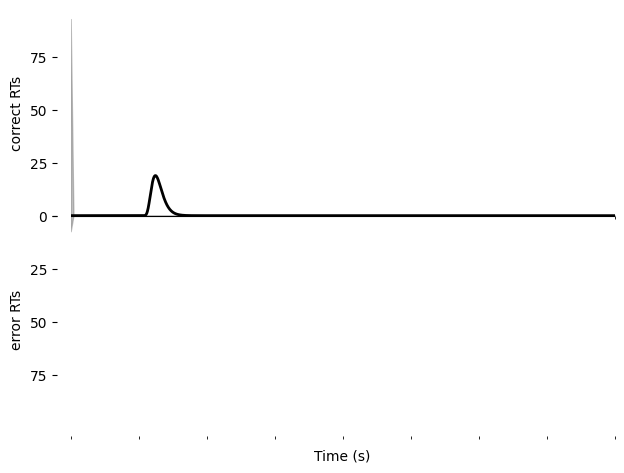

In [130]:
import pyddm.plot
import matplotlib.pyplot as plt
pyddm.plot.plot_fit_diagnostics(model=fit_model_rs, sample=switching_sample)
plt.show()